# **Module 6: Linear Modeling and Forecasting**
In our last modules, we saw that we can numerically relate two variables--either by evaluating how and when they vary together (covariance) or how variation in one variable leads to variation in another (correlation). It's now time for us to start thinking about how to determine more than just the mere **existence** of a relationship--we want to determine exactly **how** two variables relate to one another.

In this module, you will learn
* How to set up a simple linear regression
* How to set up a multiple regression
* How to set up a logistic regression
* How to interpret the output from a regression

**Be sure to expand all the hidden cells, run all the code, and do all the exercises--you will need the techniques for the lesson lab!**

#**0. Preparation and Setup**
We are working with our adult dataset again, so we're loading our libraries and our dataset just like last time, only that we won't need chisquare. This time around, we will use the following to allow us to use more statistics:
* **scipy.stats** -- all sorts of [statistical functions](https://docs.scipy.org/doc/scipy/reference/stats.html) that could potentially be useful
* **statsmodels** -- this is your typical [Python statistics package](https://www.statsmodels.org/stable/index.html). It is used for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.
* **ols** -- this is the Ordinary Least Squares function within statsmodels. It is located in the [formula class](https://www.statsmodels.org/stable/api.html#statsmodels-formula-api) and will help us set up our regression models.
* **Scikit Learn** -- we already met [this package](https://scikit-learn.org/) in this course. It is one of the most popular machine learning packages.

**The Dataset**

For this purpose, we will use the insurance prediction dataset. This dataset exists in TWO forms; the first one is the original, with [numeric and categorical attributes mixed](https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance_with_categories.csv). This dataset contains 1338 observations (rows) and 7 features (columns). The dataset contains 4 numerical features (age, bmi, children and charges) and 3 categorical features (sex, smoker and region). Later, we will encounter another version of this dataset where [the categories are converted](https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance.csv) into factors with numerical value designated for each level. Lastly, the **dependent attribute**, i.e. the **class attribute** in this datasetis charges, which tells us how high a filed claim was.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import spatial
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from IPython.display import HTML # This is just for me so I can embed videos
from IPython.display import Image # This is just for me so I can embed images

#Reading in the data as adult dataframe
insurance = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance_with_categories.csv")

#Verifying that we can see the data
insurance.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# And let's verify the datatypes before we go off into analysis land:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Let's get started!

#**1. Exploratory Data Analysis**
 Let's get a sense of how some of the independent numeric variables relate to our class attribute (i.e. the one attribute most likely to change when the independent attributes change)--in this case, our **class attribute** is incomeUSD.

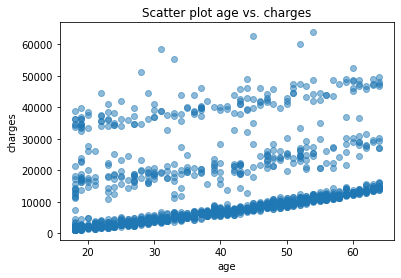

In [4]:
plt.scatter(insurance['age'], insurance['charges'], alpha=0.5)
plt.title('Scatter plot age vs. charges')
plt.xlabel('age')
plt.ylabel('charges')
plt.show()

Hm. Interesting. We see three somewhat defined bands here. The solid band at the bottom, followed by a less solid band starting between 10,000 and 20,000, and then, there's the band starting between 30 and 40k. So, the older a person gets, the more likely they are to incur higher insurance claims. Given what we know about getting older, that seems about right.

But what about the dependency of [bmi](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm) and charges? Might it be reasonable to assume that higher bmi = higher charges?  Well, let's see ...

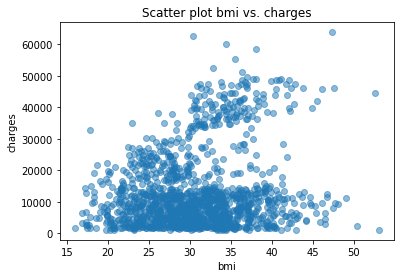

In [5]:
plt.scatter(insurance['bmi'], insurance['charges'], alpha=0.5)
plt.title('Scatter plot bmi vs. charges')
plt.xlabel('bmi')
plt.ylabel('charges')
plt.show()

**SURPRISE!** Higher bmi does not always mean higher insurance charges! We see plenty of data in the 40+ ranges that seem to have identical charges to data in the 20 to 25 range. HOWEVER, we also see more data breaking the 30,000 barrier starting at a bmi of 30+. So ... two relationships, really?

Next, let's check the correlations between all the attributes:

In [6]:
insurance.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


## Your Turn
Look at the table above. Which attribute has the best correlation to charges? Display just this attribute in this field:

##Your Turn
Now, does having more children mean higher charges? Let's see! 

Use the field below to build a scatterplot of children and charges! What does the relationship reveal?

Really think about this--wouldn't it be interesting if we could find the rule that connects these variables?

# **2. Simple Regression**
In the previous module, we saw how Correlation and the Pearson Correlation Coefficient, r, give us a first insight into the relationship between two variables. But that is only 1 number which doesn't tell us anything about the relationship of each single datapoint with the next--and it certainly doesn't allow us to predict any future values.

That is why Regression is a better aproach. Did you know that there are [**7 different types** of regression](https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/)? No worries, though. We won't walk through **all** of those.


##**2.1 Simple Linear Regression with statsmodels**
The simplest regression comes in the form of 

                    `y = f(x) + b`

where x is the independent variable and y the dependent variable (aka the class attribute). The idea is that you can find a coefficient for x (here named f) that, when paired with a constant value (here b), will allow you to calculate any dependent value y. Since there is no exponential math going on here, the result will be a straight line. That's also why we call this "linear regression." 

So, how does simple linear regression work? Well, you've already taken the first steps by plotting the independen variable x on the dependent variable y above. The rest is explained in this excellent 15-minute video below (and if you have ever wondered about beer sales and outside temperature, this video is definitely for you):



In [7]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/aq8VU5KLmkY" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

###**2.1.1 Simple Linear Regression with statsmodels**
Below, we will use Ordinary Least Squares to calculate our regression equation. As the video above explains, Ordinary Least Squares, or linear least squares, estimates the parameters in a regression model by minimizing the sum of the squared residuals. This method draws a line through the data points that minimizes the sum of the squared differences between the observed values and the corresponding fitted values.

If you can't remember what residuals are, check out [this blog post](https://www.statisticshowto.com/residual/).

So, let's go back to age and insurance charges! Note that, in order to format our output as 

                          `y = f(x) + b`

We need to make sure that the calculation considers the constant b. That's why we use add_constant below. Otherwise, all we would get as output is the coefficient f.

In [8]:
X = insurance['age']
y = insurance['charges']
X = sm.add_constant(X)
insurance.mod1 = sm.OLS(y, X).fit()  ## sm.OLS(output, i.e. dependent variable, input, i.e. independent variable)
insurance.mod1_summary = insurance.mod1.summary()
print(insurance.mod1_summary)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Mon, 14 Jun 2021   Prob (F-statistic):           4.89e-29
Time:                        16:48:52   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.8850    937.149      3.378      0.0

### **WHOA! T.M.I.!--Understanding the Output**

We're seeing a lot of information here. 

**Most important**: Point your eyes a little below the middle of this output. That's where you'll see the following:
```
         coef	    std err	 t	    P>|t|	[0.025	  0.975]
const	3165.8850	937.149	3.378	0.001	1327.440	5004.330
age	   257.7226	22.502	11.453	0.000	 213.579	301.866
```
**What does this mean?**

The first number here is const coef, that is, the constant in our linear equation, here 3165.8850. It is the value for our letter b in 

                               `y = f(x) + b`

The second important number here is age coef, that is, the factor by which we multiply the independent variable, here 257.7226. It is the value for f. So, the equation that OLS has built for us is

                              `y = (257.7226 * x) + 3165.8850`


The coefficient of 257.7226 means that as the age variable increases by 1, the predicted value of charges increases by 257.7226 plus 3165.8850.  

We also meet an "old friend" again--the p value in the P>|t| column. Since the initial assumption, that is, the H0, of a Regression is always that all variables are independent from each other, the p value shows us how many %  of the result are really due to random chance. Remember how we learned that the magic threshold is 5%, and "if p is low, H0 must go"? With p being at 0.000, we're seeing here that age and charges are obviously dependent.

**Now, let's look at this:** 
```
                         OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
....
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04                                         
==============================================================================

```
Let's start at the bottom: The number of observations is 1338, which, since we are looking at 2 attributes, makes the degrees of freedom 1338 - 2 = 1336. No problem here. Let's move up. The R-squared value of 0.089 or 8.9% means that 8.9% of the variation in charges can be explained by using age as the predictor. 

To learn more about how to interpret the entire output, check out [this excellent video](https://www.youtube.com/watch?v=VvlqA-iO2HA).

**Wait, what?**

Let's look at these numbers again:

In [9]:
print('Parameters: ', insurance.mod1.params)
print('R2: ', insurance.mod1.rsquared)

Parameters:  const    3165.885006
age       257.722619
dtype: float64
R2:  0.08940589967885781


The R-squared value is 8.9%! If we compare this to our initial impression from the scatter diagram and the p-value interpretation above, namely that age could well be closely related to charges, th R-squared value makes age a lousy predictor of most of the charges. **LOUSY**!

Let's take a look at the calculated values for x (the video called them y "hat") and then plot them:

In [10]:
predictions = insurance.mod1.predict(X) # Here, you'll see the CALCULATED values with the formula
predictions

0        8062.614761
1        7804.892142
2       10382.118329
3       11670.731422
4       11413.008803
            ...     
1333    16052.015939
1334     7804.892142
1335     7804.892142
1336     8578.059998
1337    18886.964745
Length: 1338, dtype: float64

###**2.1.2 Plotting the results**
Now let's build all four regression plots. We pass in the model as the first parameter, then specify the predictor variable we want to analyze.

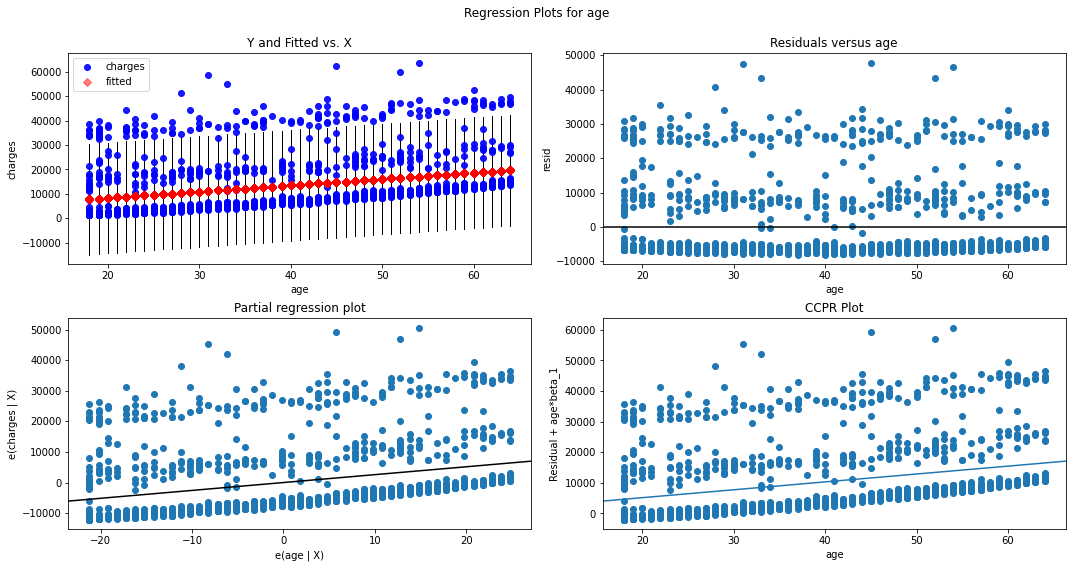

In [11]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(insurance.mod1, "age", fig=fig)

**WOW**! Remember the R-squared number of 8.9%? Here you can see the distribution of values for the age variable. Look at the plot in the upper left-hand corner of the fitted, i.e. predicted vs. actual values. That fit line isn't all that representative, is it--although there's clearly some connection (so, the p-value was correct)? And the residuals, which should be centered around 0? Check out the upper right-hand corner graph--obviously not the case, is it?

## **2.2. Multiple Linear Regression with scikit learn**--Numeric Attributes

Well. We've seen where looking at just ONE variable in connection with our insurance charges got us--not too far. So ... what if we look at a few variables together as joint influencers of the charge variable? Perhaps that will increase the R-squared value. When we run a regression with more than one independent attribute in the X variable, that is called Multiple Regression. Here, we are using the linear model, so we are performing Multiple Linear Regression.

Now, we could do this in statsmodels--but that'll be your job later. To shake things up, we will use another very popular and versatile package for this purpose: Scikit Learn. In our preparation and setup section, we already imported its linear_model subpackage.

We will focus our Multiple Regression on the joint influence of age, bmi, and number of children on charges. You have already encountered these three in section 1 of this workbook.

In [12]:
# Let's use the three "big" predictor variables from above: age, bmi, and number of children

X = insurance[['age','bmi','children']] # Now we have values from three different independent attributes stored in X
y = insurance['charges'] # This is, again, our dependent attribute
print(X) # This is the content of our X variable

      age     bmi  children
0      19  27.900         0
1      18  33.770         1
2      28  33.000         3
3      33  22.705         0
4      32  28.880         0
...   ...     ...       ...
1333   50  30.970         3
1334   18  31.920         0
1335   18  36.850         0
1336   21  25.800         0
1337   61  29.070         0

[1338 rows x 3 columns]


In [13]:
# Defining the model for a multiple regression using the lm.fit() function:

lm = linear_model.LinearRegression() # Here, we are using the linear_model subpackage from scikit-learn that we imported above
model = lm.fit(X,y) # And here, we are building the model

You will have noticed that, when you clicked on the previous code cell, the output was ... nothing. When we run a linear regression with SKLearn, we don’t get a pretty table like in Statsmodels. But then, the model is much easier to build. What we can do is use built-in functions to return the score, the coefficients and the estimated intercepts. Let’s see how it works:

In [14]:
# To find the R-squared score:
lm.score(X,y)

0.12009819576246927

In [15]:
# To find the coefficients for the predictors:
lm.coef_

array([239.99447429, 332.0833645 , 542.86465225])

In [16]:
# To find the intercept:
lm.intercept_

-6916.243347787033

What does all of this mean? Well, the R-squared value has improved from 8.9% to 12%. That's something. We are seeing our coefficients and the intercept, as well. This makes our equation


```
charges = 239.99 * age + 332.08 * bmi + 542.86 * children - 6916.24

```
As I said: Better already. Good? Not good enough. There's got to be a better way. And there is.


## **2.3 Multiple Linear Regression--All Attributes**
Remember the other attributes we have in this dataset? Let's take a quick look:

In [17]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We still have sex, smoker, and region! Let's see what their influence is when combined with our numeric attributes.

First, we set up our X and y attributes again.

In [18]:
X = insurance.iloc[:, :-1].values
y = insurance.iloc[:, 6].values
print(X)
print(y)

[[19 'female' 27.9 0 'yes' 'southwest']
 [18 'male' 33.77 1 'no' 'southeast']
 [28 'male' 33.0 3 'no' 'southeast']
 ...
 [18 'female' 36.85 0 'no' 'southeast']
 [21 'female' 25.8 0 'no' 'southwest']
 [61 'female' 29.07 0 'yes' 'northwest']]
[16884.924   1725.5523  4449.462  ...  1629.8335  2007.945  29141.3603]


Now, we can run our Multiple Regression again--this time with a process called "Backward Elimination." In short, **Backward Elimination** is the process of entering all the independent variables into the equation first and delete them one at a time if they do not contribute to the regression equation.

Time to get up close and personal with r-squared!

###**OH!**
But since regression requires only numeric variables, we will need to work with an entirely numeric dataset. Good thing we have one--otherwise, we would need to do some serious preprocessing. Let's load this dataset:

In [19]:
insurance2 = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance.csv")
insurance2.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


There is an additional column called "insuranceclaim". We will delete this column for now. (NOTE: If you click the "run" icon below more than once, you will get a runtime error because Python is trying to delete a column that has already been deleted).

In [20]:
del insurance2['insuranceclaim']
insurance2.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Now we can start eliminating attributes if they don't contribute to an optimal regression result (again, let's watch r-squared). We will use statsmodels this time around. First, we will set up X and y again so that we replace the strings currently in these variables with numbers:



In [21]:
X = insurance2.iloc[:, :-1].values
y = insurance2.iloc[:, 6].values

X = np.append(arr = np.ones((1338, 1)).astype(int), values = X, axis = 1) # We are building our numpy array

X_opt = X[:, [0, 1, 2, 3, 4, 5, 6]] # Now we combine all 6 input variables into our first iteration
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.1
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:48:53   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.182e+04    955.130    -12.371      0.0

Wow! With all variables combined, we can achieve and r-squared value of 75%. Nice. But you never know if two variables maybe negatively impact each other. So, let's remove one and see if that will help us increase r-squared.

In [22]:
# How about age? That wasn't so good before. 

X_opt = X[:, [0, 2, 3, 4, 5]] # Age has been removed
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     651.6
Date:                Mon, 14 Jun 2021   Prob (F-statistic):          9.46e-312
Time:                        16:48:53   Log-Likelihood:                -13753.
No. Observations:                1338   AIC:                         2.752e+04
Df Residuals:                    1333   BIC:                         2.754e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3952.3555   1016.546     -3.888      0.0

Oh. Well, that actually decreased R-squared. How about eliminating sex?

In [23]:
# bmi looked pretty split before. Removing bmi now.

X_opt = X[:, [0, 2, 4, 5, 6]] # Age has been removed
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     552.2
Date:                Mon, 14 Jun 2021   Prob (F-statistic):          5.67e-281
Time:                        16:48:53   Log-Likelihood:                -13824.
No. Observations:                1338   AIC:                         2.766e+04
Df Residuals:                    1333   BIC:                         2.768e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7889.1464    447.098     17.645      0.0

Wow. That dropped the r-squared function even faster. How about bmi, then?

In [24]:
X_opt = X[:, [0, 1, 3, 4, 5, 6]] # Removed bmi
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     802.2
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:48:54   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.187e+04    945.876    -12.546      0.0

Heh. Removing bmi did nothing to our r-squared--except for saving us the processing power that would come from applying the regression to the full dataset including bmi.

In [25]:
X_opt = X[:, [0, 1, 3, 4, 6]] # Removing bmi and region
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     46.00
Date:                Mon, 14 Jun 2021   Prob (F-statistic):           3.07e-36
Time:                        16:48:54   Log-Likelihood:                -14391.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1333   BIC:                         2.882e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6661.4688   1767.161     -3.770      0.0

Well, looks like we definitely want to keep region! What about smoker?

In [26]:
X_opt = X[:, [0, 1, 3, 5, 6]] # Removing bmi and smoker
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # Now we set up our regressor function with OLS again as before.
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     991.5
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:48:54   Log-Likelihood:                -13554.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.144e+04    941.848    -12.148      0.0

Wow. We just saved ourselves processing 2,600 values and lost less than 1 percent in our r-squared value. That seems like a pretty good deal!

##**WAIT! What's the Goal?**

We started this entire regression business because we wanted to find a function that would allow us to **PREDICT** future values of the charges attribute. This means that we would want to combine all our X inputs (as we did above) in order to find y values based on the regression formula. This also means that we need more independent attributes with no values in the associated y attribute, so that we can actually **CALCULATE** y. 

But our dataset is clean, with 1338 values in each column. 

So ... we need to either invent more independent attribute values, OR we need to delete some of those y attribute data, so that we can actually calculate them.

Inventing data is a big no-no when you're dealing with actual data (although data scientists will often create artificial datasets to prove a theory). This means that the only other thing left to us is to delete data from the y column. 

But how? And how much?



##**2.4 Training and Test Datasets**
What we really need at this point is two different datasets. We need one dataset to build, or **TRAIN**, our regression function. Then, we can use a second dataset on which to **TEST** whether our function actually works. However, since we have only one dataset, we will have to
* Split the dataset into a larger training dataset and a smaller testing dataset
* Build our function on the basis of the training dataset
* Remove the y values in the test dataset
* Apply our function to the test dataset
* Compare the computed values for the test dataset (the Y hat values!) with the actual values in y that we did, of course, not throw away entirely.

In fact, that's what we will do with all data from hereon out.

###**2.4.1 Building the Training and Test Set**
We will use the generic train_test_split function from scikit-learn for this. We will build a separate X_train and X_test frame and a y_train and a y_test frame.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size = 0.2, random_state = 0) # Size of test data is 20%, size of training data is 80%

print('X Train', X_train.shape)
print('X Test', X_test.shape)

X Train (1070, 5)
X Test (268, 5)


###**2.4.2 Finding the Regression Formula**
Now we can find the regression formula in the training set!

In [28]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('Model accuracy score:', round(regressor.score(X_train,y_train)*100,2))

Model accuracy score: 73.48


The model accuracy score is basically the r-squared value expressed as percentage and rounded to two decimals. Good.

###**2.4.3 Applying the Regression Formula to the Test Set**
Now we can plug our X_test set values into the formula and calculate the y_test values to predict. In order not to confuse the actual y_test values with the values we are going to calculate, we will call our predicted values y_pred. 

In [29]:
y_pred = regressor.predict(X_test)
print(y_pred[0:10])

[11120.40787644  9830.57702054 37641.23907107 16645.5937302
  7396.20737603  4398.47127815  1923.90465065 13427.18898623
  8065.19024546  6552.89896696]


###2.4.4 Comparing predictions and actual values in the test set
What good are the predictions if you can't tell how close to reality they are? That's where our y_test comes in. Now we can compare our y_pred and y_test, and we will see how good our prediction is. 

In [30]:
charges_pred = pd.DataFrame({'Prediction (y_pred)':y_pred,'Actual Values (y_test)':y_test}).round(2)
print(charges_pred.shape)
charges_pred.head(25)

(268, 2)


,Prediction (y_pred),Actual Values (y_test)
0,11120.41,9724.53
1,9830.58,8547.69
2,37641.24,45702.02
3,16645.59,12950.07
4,7396.21,9644.25
5,4398.47,4500.34
6,1923.90,2198.19
7,13427.19,11436.74
8,8065.19,7537.16
9,6552.90,5425.02


We can see that the y_pred data are a bit more extreme on each end than the y_test data. That's why accuracy is at around 73%--not great, but certainly better than 8.9% or 12%.

# **3. Classification with Logistic Regression**
You just learned how to use Simple Regression and a training/ test set split to calculate and predict **numeric output**. That's because Regression is a mathematical tool. 

But what if we are interested in **categorical output**? What if we want to use a student's grades to predict whether they will pass or fail a class at the end of the semester? Or use a soccer team's past number of goals in a tournament to determine if it will win or lose the World Cup? Or see if  body weight, calorie intake, fat intake, and age have an influence on the probability of having a heart attack (yes vs. no)?




We will use the first insurance dataset again, but with an additional insuranceclaim dimension that contains 1 (claim valid) or 0 (claim invalid). We are setting the dataframe up from scratch again first, though.

##**3.1 What is Logistic Regression?**
We have already seen the questions Logistic Regression tries to answer. Basically, there are THREE RULES for Logistic Regression:
1. The dependent variable should be dichotomous (e.g., yes/ no, present/ absent, pass/ fail, and so on).
2. There should be no outliers in the data.
3. There should be no high correlations (multicollinearity) among the predictors (i.e. we'll have to set up a correlation matrix among the predictors and look for small Pearson Correlation Coefficients (r, with which we have already worked multiple times). 

###**How does Logistic Regression Work?**
Logistic Regression isn't all that different from Multiple Linear Regression. But where the output of Multiple Linear Regression is continuous, the output of Logistic Regression is binary or "dichotomous." In other words, we don't want a number at the end; we want one of two values. That requires some additional math--namely [a logistic function](https://careerfoundry.com/en/blog/data-analytics/what-is-logistic-regression/), which is based on calculating the odds of an outcome. For example, let's say that, since in the past your soccer team has won 20 out of 21 games in the World Cup tournament, the odds of them winning finals are 20 to 21, or, when expressed as an odds ratio, they are 20/21. To standardize these odds ratios to a 1 or 0 outcome, we need the *logit function*, which is there Logistic Regression gets its name. This function applies a log odds logarithm to the outcome of a multiple regression. 

To learn more about the math behind Logistic Regression, watch this great 9-minute video: 


In [31]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/yIYKR4sgzI8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

##**3.2 Working with Logistic Regression**
Here is how Logistic Regression works for our example:

Remember how, when working with the insurance2 dataset, we deleted that insuranceclaim column? Well, we are going to use it now. For that purpose, we are reading the dataset in again and name it insurance3.

In [32]:
insurance3 = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance.csv")
insurance3.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


###**3.2.1 Satisfying the Three Rules**
We already see that insuranceclaim is binary or dichotomous and seems to have values of 1 and 0. That satisfies Rule #1 above. On to our second rule--we need to check for multicollinearity, i.e. connections among the attributes themselves. For that, we are setting up a correlation matrix:

In [33]:
corr = insurance3.corr()
corr

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008,0.113723
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292,0.031565
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341,0.384198
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998,-0.409526
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251,0.333261
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208,0.020891
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000,0.309418
insuranceclaim,0.113723,0.031565,0.384198,-0.409526,0.333261,0.020891,0.309418,1.000000


##Your Turn
Which variables have > 50% correlation? Type the variable below:

To make things fancy, we can even visualize the correlations in a heat map using the [seaborn package](https://seaborn.pydata.org/introduction.html), which is one of the really great graphics packages in Python! This works like so (and will give you the answer to the Your Turn question above):

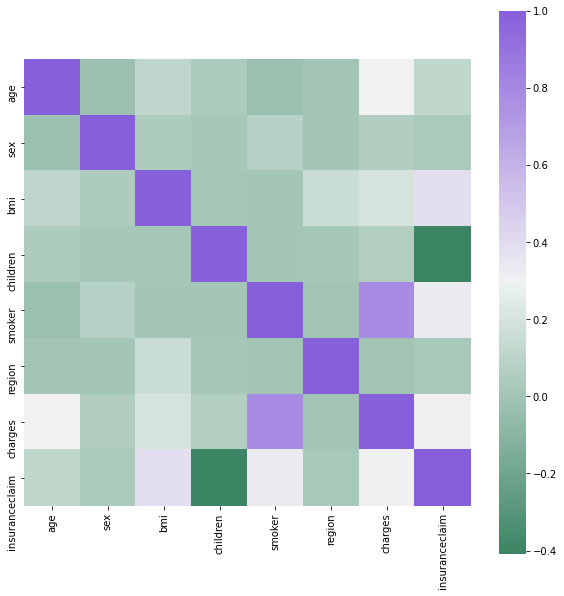

In [34]:
import seaborn as sns

f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), 
            cmap = sns.diverging_palette(150, 275, as_cmap = True), square = True, ax = ax)

Compare what you see on this heatmap of correlations with the answer you typed in the field above. Does your answer match what we see here?

###**3.2.2 Preprocessing the Data: Training and Test Set**
The data set consists of record of 1338 patients in total. To train our model we will be using 1000 records. We will be using 300 records for testing, and we will use the last 38 records to cross check our model. Instead of splitting percentage-wise, as we did above, we are now splitting by row number:

In [35]:
dfTrain = insurance3[:1000]
dfTest = insurance3[1000:1300]
dfCheck = insurance3[1300:]

Next, we separate the label and features (for both training and test dataset). In addition to that, we will also convert them into NumPy arrays as our machine learning algorithm processes data in NumPy array format.

In [36]:
train_y = np.asarray(dfTrain['insuranceclaim']) # We store insuranceclaim in train_y, but as numpy array
train_x = np.asarray(dfTrain.drop('insuranceclaim',1)) # We remove insurancelcaim from the predictors (because it's the output variable)
test_y = np.asarray(dfTest['insuranceclaim']) # See the comments above
test_x = np.asarray(dfTest.drop('insuranceclaim',1))
train_x 

array([[1.90000000e+01, 0.00000000e+00, 2.79000000e+01, ...,
        1.00000000e+00, 3.00000000e+00, 1.68849240e+04],
       [1.80000000e+01, 1.00000000e+00, 3.37700000e+01, ...,
        0.00000000e+00, 2.00000000e+00, 1.72555230e+03],
       [2.80000000e+01, 1.00000000e+00, 3.30000000e+01, ...,
        0.00000000e+00, 2.00000000e+00, 4.44946200e+03],
       ...,
       [6.30000000e+01, 0.00000000e+00, 3.68500000e+01, ...,
        0.00000000e+00, 2.00000000e+00, 1.38879685e+04],
       [3.30000000e+01, 0.00000000e+00, 3.62900000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 6.55175010e+03],
       [3.60000000e+01, 0.00000000e+00, 2.68850000e+01, ...,
        0.00000000e+00, 1.00000000e+00, 5.26781815e+03]])

This is what the numpy array looks like. No worries. All the data is there.

As the final step before using machine learning, we will normalize our inputs. Machine Learning models often benefit substantially from input normalization. It also makes it easier for us to understand the importance of each feature later, when we’ll be looking at the model weights.  We’ll normalize the data such that each variable has 0 mean and standard deviation of 1.

In [37]:
means = np.mean(train_x, axis=0)
std = np.std(train_x, axis=0)
 
train_x = (train_x - means)/std
test_x = (test_x - means)/std

Now, we can start with our Logistic Regression!

###**3.2.3 Building the Model**
We can now train our classification model with logistic regression. First, we create a model and then use the fit function to train the model. We use the [LogisticRegression() function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from scikit-learn. Follow the link to learn more about this very versatile function!

In [38]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###**3.2.4 Testing the Model**
Now we use our test data to determine the accuracy of the model.

In [39]:
accuracy = model.score(test_x, test_y)
print("accuracy = ", accuracy * 100, "%")

accuracy =  86.0 %


###**3.2.5 Using the Model for Predictions**
NOw we can use the model for predictions on the test set!

In [40]:
pred = model.predict(test_x)
print(pred)

[1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0
 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1
 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0
 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 0 0 0]


And here is our entire analysis process--and the calculated output! We are seeing how the function allowed us to predict 1 or 0, just as we needed!

In [41]:
# Let's compare the actual y and the predicted y

realvsmodel = pd.DataFrame(pred,test_y)
realvsmodel = pd.DataFrame({'predicted':pred,'original':test_y})
realvsmodel.head(25)

,predicted,original
0,1,0
1,1,1
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,0,0


##Your Turn
1. Create a subset of the adult dataset with just the numeric variables. 
2. Can you use Logistic Regression to predict the sex of someone based on the all the numeric inputs? Use this as your guiding question for your exploration. Follow all the steps in section 3.2.